In [7]:
import torch
import argparse
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
from thop import profile, clever_format

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader
from ptsemseg.utils import convert_state_dict

torch.backends.cudnn.benchmark = True
import cv2 


In [8]:
#model_path  = 'hardnet70_cityscapes_model_2.pkl'
model_path = 'runs/hardnet/cur/hardnet_cityscapes_best_model.pkl'
size = (1080, 1920) 

In [9]:
model = get_model({"arch": "hardnet"}, 7)

In [10]:
state = convert_state_dict(torch.load(model_path, map_location='cpu')["model_state"])
model.load_state_dict(state)
model.eval()
model.cuda()


hardnet(
  (base): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvLayer(
      (conv): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): ConvLayer(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): ConvLayer(
      (conv): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [11]:
img_paths = glob.glob('/mnt/sandbox/datasets/RGB/drone_deploy/dataset-medium/image-chips/val/*')

In [12]:
img_path

NameError: name 'img_path' is not defined

In [31]:
LABEL_MAP = {
    1 : (200, 200, 200), #BUILDING
    5 : (180, 30, 145), #CLUTTER
    2 : (75, 180, 60), #VEGETATION  GOOD
    3 : (48, 130, 245), #WATER
    4 : (255, 255, 255), #GROUND    GOOD
    6 : (0, 0, 200), #CAR
    7 : (255, 0, 255)  #IGNORE
    }

def category2mask(img):
    """ Convert a category image to color mask """
    if len(img) == 3:
        if img.shape[2] == 3:
            img = img[:, :, 0]

    mask = np.zeros(img.shape[:2] + (3, ), dtype='uint8')

    for category, mask_color in LABEL_MAP.items():
        locs = np.where(img == category)
        mask[locs] = mask_color

    return mask

[1 2 3]
[2 3 4]


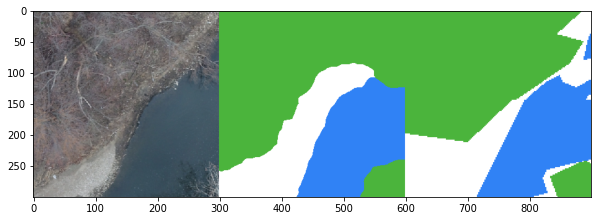

In [32]:
#img_path = np.random.choice(img_paths, replace=True)

im = cv2.imread(img_path)[:,:,::-1]
#im = cv2.imread('lake.jpg')[:,:,::-1]
#im = cv2.imread('city_intersection.jpg')[:,:,::-1]
gt = cv2.imread(img_path.replace('image-chips', 'label-chips'))

#img_resized = cv2.resize(img, (size[1], size[0]))  # uint8 with RGB mode
img = im.astype(np.float16)

# norm
value_scale = 255
mean = [0.406, 0.456, 0.485]
mean = [item * value_scale for item in mean]
std = [0.225, 0.224, 0.229]
std = [item * value_scale for item in std]
img = (img - mean) / std

# NHWC -> NCHW
img = img.transpose(2, 0, 1)
img = np.expand_dims(img, 0)
img = torch.from_numpy(img).float()

images = img.cuda()
outputs = model(images)
pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)

print(np.unique(pred))
print(np.unique(gt))

plt.figure(figsize=(10,30))
plt.imshow(np.concatenate([im, category2mask(pred+1), category2mask(gt[:,:,0] )], axis=1))
#plt.imshow(np.concatenate([im[:,:,0]/np.max(im[:,:,0]), pred/np.max(pred), gt[:,:,0]/np.max(gt[:,:,0])], axis=1))

#plt.imshow(im)
#plt.figure()
#plt.imshow(pred)
#plt.figure()
#plt.imshow(gt[:,:,0])

In [89]:
gt[0,299]

array([5, 5, 5], dtype=uint8)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

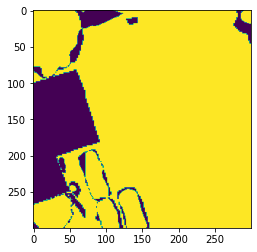

In [13]:
match = ((pred+1) == gt[:,:,0]) * 255
plt.imshow(match)
pred

In [76]:
gt[0,299,0]

3

In [27]:
macs, params = profile(model, inputs=(images, ))
macs, params = clever_format([macs, params], "%.3f")
macs, params

('34.845G', '4.119M')

In [68]:
pred[0,0]

1

In [41]:
plt.imshow(im)

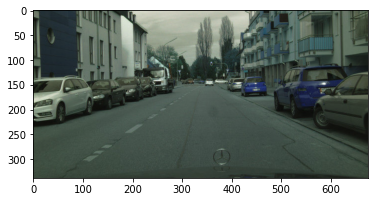

In [17]:
plt.imshow(cv2.imread('cityscapes_sample.jpg'))

In [25]:
times = [] 
for ii in range(20):
    start = time.time()
    outputs = model(images)
    torch.cuda.synchronize()
    times.append(time.time() - start)
    
print(1 / np.mean(times))
    
    


56.555247600048276
